### Import Libraries

In [135]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras
from sklearn.metrics import confusion_matrix, classification_report, f1_score 
import seaborn as sns
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers , models
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
import os, random, shutil
import matplotlib.image as img

In [136]:
# Load dataset
source_path = pathlib.Path('./Rice_Image_Dataset')

In [137]:
label = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

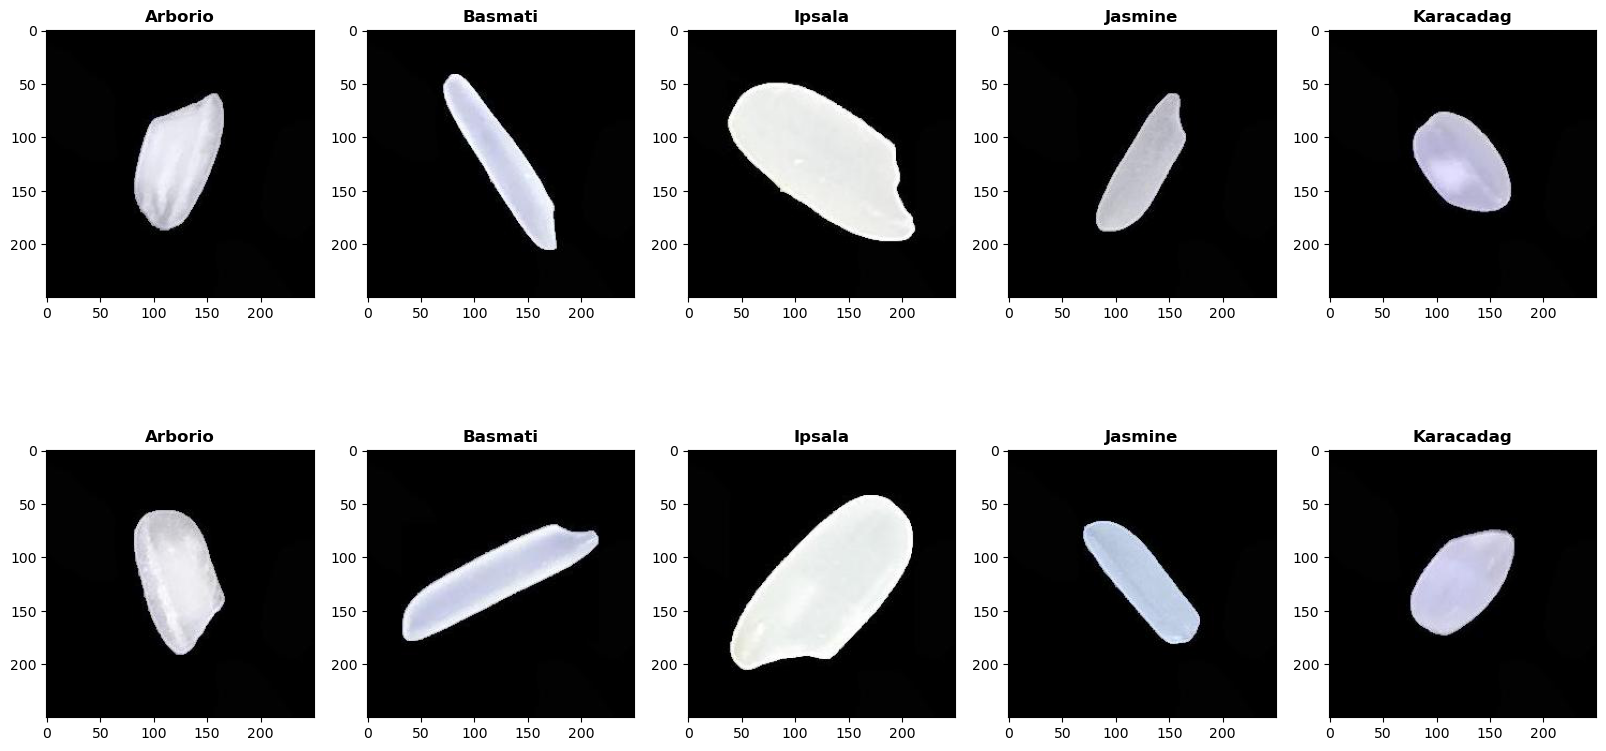

In [138]:
fig = plt.figure(figsize = (20, 10))
image_position = 0

for j in range(2):
    for index, folder in enumerate(label):
        image_position += 1
        folder_path = os.path.join(source_path, folder)
        
        fig.add_subplot(2, 5, image_position)
        plt.title(folder, fontweight='bold')
        plt.imshow(img.imread(os.path.join(folder_path, random.choice(os.listdir(folder_path)))))

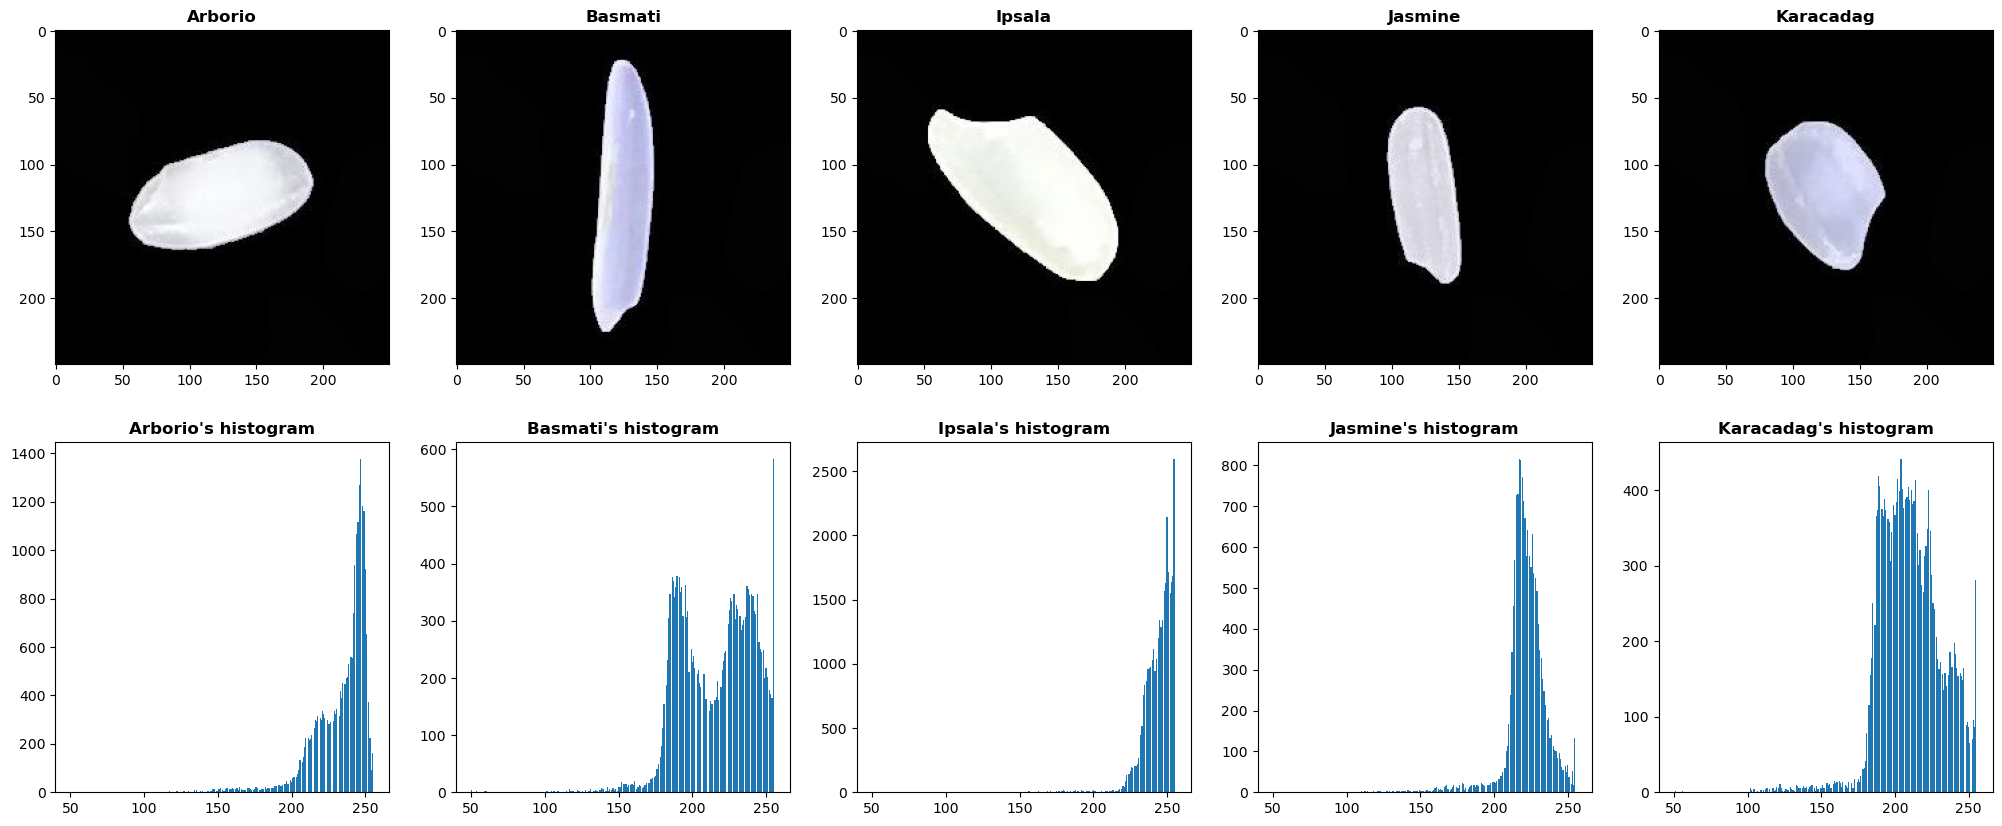

In [139]:
fig = plt.figure(figsize = (25, 10))
image_position = 0

for index, folder in enumerate(label):
    image_position += 1
    folder_path = os.path.join(source_path, folder)

    fig.add_subplot(2, 5, image_position)
    plt.title(folder, fontweight='bold')
    
    image = img.imread(os.path.join(folder_path, random.choice(os.listdir(folder_path))))
    
    # Plot image
    plt.imshow(image)
    
    # Plot its histogram
    fig.add_subplot(2, 5, image_position+5)
    plt.title(f"{folder}'s histogram", fontweight='bold')
    plt.hist(image.ravel(), bins=256, range=[50, 256])

In [141]:
target_path = 'splitted'

os.makedirs(os.path.join(target_path, 'train'))
os.makedirs(os.path.join(target_path, 'test'))

for l in label:
    os.makedirs(os.path.join(target_path, f'train/{l}'))
    os.makedirs(os.path.join(target_path, f'test/{l}'))

In [142]:
from collections import Counter

for l in label:
    full_dataset_from_this_class = os.listdir(os.path.join(source_path, l))
    to_be_train_set = random.sample(full_dataset_from_this_class, 10500)
    to_be_test_set = list((Counter(full_dataset_from_this_class) - Counter(to_be_train_set)).elements())
    
    # move to next folder
    for file_name in to_be_train_set:
        shutil.copyfile(
            os.path.join(source_path, l, file_name),
            os.path.join(target_path, f'train/{l}', file_name)
        )
        
    for file_name in to_be_test_set:
        shutil.copyfile(
            os.path.join(source_path, l, file_name),
            os.path.join(target_path, f'test/{l}', file_name)
        )

In [143]:
train_path = os.path.join(target_path, 'train')
test_path = os.path.join(target_path, 'test')

In [144]:
image_data_generator = ImageDataGenerator(
    rescale=1./255
)

In [145]:
train_generator = image_data_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical'
)

test_generator = image_data_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    shuffle=True,
    class_mode='categorical'
)

Found 52500 images belonging to 5 classes.
Found 22500 images belonging to 5 classes.


### Model 1 - ResNet50

In [146]:
from tensorflow.keras.applications import ResNet50

In [147]:
# Load pre-trained model
base_model1 = ResNet50(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model1.trainable = False

In [148]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model1(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_18 (Flatten)        (None, 100352)            0         
                                                                 
 dense_36 (Dense)            (None, 32)                3211296   
                                                                 
 dense_37 (Dense)            (None, 5)                 165       
                                                                 
Total params: 26799173 (102.23 MB)
Trainable params: 3211461 (12.25 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [149]:
model1.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [150]:
# Fit the model
history_m1 = model1.fit(
    train_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
821/821 [==============================] - 300s 356ms/step - loss: 1.2424 - accuracy: 0.8396
Epoch 2/10
821/821 [==============================] - 286s 348ms/step - loss: 0.1461 - accuracy: 0.9530
Epoch 3/10
821/821 [==============================] - 282s 343ms/step - loss: 0.1177 - accuracy: 0.9594
Epoch 4/10
821/821 [==============================] - 284s 346ms/step - loss: 0.0979 - accuracy: 0.9645
Epoch 5/10
821/821 [==============================] - 287s 349ms/step - loss: 0.0923 - accuracy: 0.9688
Epoch 6/10
821/821 [==============================] - 286s 348ms/step - loss: 0.0911 - accuracy: 0.9687
Epoch 7/10
821/821 [==============================] - 283s 345ms/step - loss: 0.0911 - accuracy: 0.9684
Epoch 8/10
821/821 [==============================] - 284s 346ms/step - loss: 0.0849 - accuracy: 0.9711
Epoch 9/10
821/821 [==============================] - 288s 350ms/step - loss: 0.0837 - accuracy: 0.9717
Epoch 10/10
821/821 [==============================] - 285s 347m

In [151]:
model1.evaluate(test_generator)

352/352 [==============================] - 132s 360ms/step - loss: 0.0679 - accuracy: 0.9771


[0.06788882613182068, 0.977066695690155]

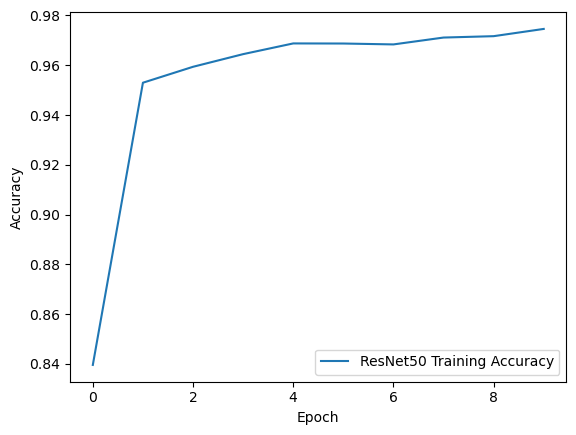

In [214]:
plt.plot(history_m1.history['accuracy'], label='ResNet50 Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

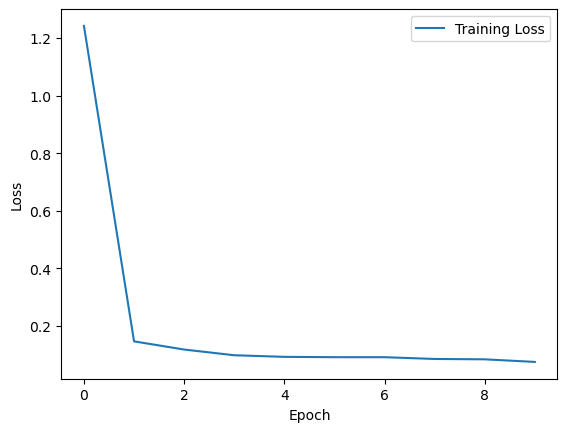

In [154]:
plt.plot(history_m1.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 26ms/step


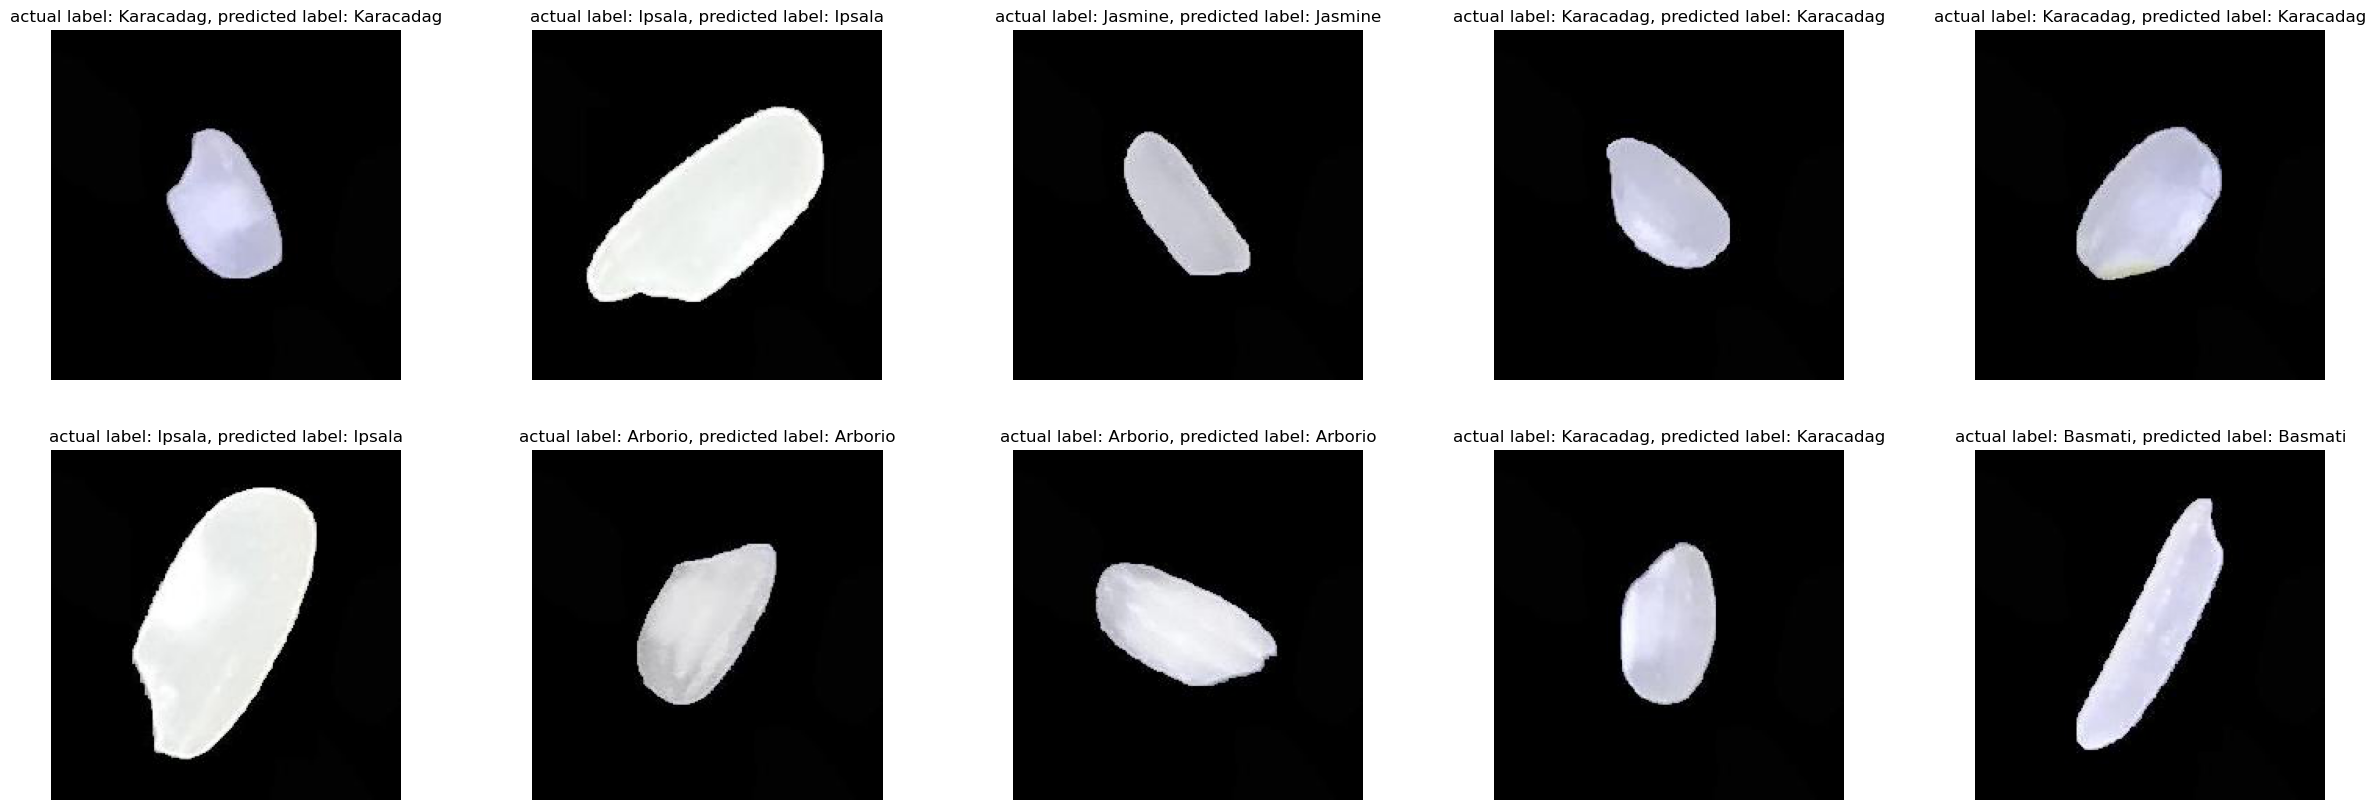

In [155]:
# use Model 1 to predict the rice class
img, l = next(iter(test_generator))

plt.figure(figsize=(30,10))
for i in range(10):
    actual_label = list(label)[np.argmax(l[i])]
    predicted_label = np.argmax(model1.predict(img[i][None,...]))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(img[i]))
    plt.title(f'actual label: {actual_label}, predicted label: {list(label)[predicted_label]}')

### Model 2: InceptionV3

In [156]:
from tensorflow.keras.applications import InceptionV3

In [157]:
# Load pre-trained model
base_model2 = InceptionV3(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model2.trainable = False

In [158]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model2(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_19 (Flatten)        (None, 51200)             0         
                                                                 
 dense_38 (Dense)            (None, 32)                1638432   
                                                                 
 dense_39 (Dense)            (None, 5)                 165       
                                                                 
Total params: 23441381 (89.42 MB)
Trainable params: 1638597 (6.25 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [159]:
model2.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [160]:
# Fit the model 
result_m2 = model2.fit(
    train_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
821/821 [==============================] - 195s 224ms/step - loss: 0.9147 - accuracy: 0.9436
Epoch 2/10
821/821 [==============================] - 172s 209ms/step - loss: 0.1390 - accuracy: 0.9774
Epoch 3/10
821/821 [==============================] - 171s 208ms/step - loss: 0.0811 - accuracy: 0.9845
Epoch 4/10
821/821 [==============================] - 172s 209ms/step - loss: 0.0644 - accuracy: 0.9873
Epoch 5/10
821/821 [==============================] - 173s 210ms/step - loss: 0.0503 - accuracy: 0.9899
Epoch 6/10
821/821 [==============================] - 172s 209ms/step - loss: 0.0446 - accuracy: 0.9909
Epoch 7/10
821/821 [==============================] - 172s 209ms/step - loss: 0.0449 - accuracy: 0.9915
Epoch 8/10
821/821 [==============================] - 172s 210ms/step - loss: 0.0368 - accuracy: 0.9922
Epoch 9/10
821/821 [==============================] - 171s 208ms/step - loss: 0.0326 - accuracy: 0.9932
Epoch 10/10
821/821 [==============================] - 170s 207m

In [162]:
model2.evaluate(test_generator)

352/352 [==============================] - 96s 242ms/step - loss: 0.0631 - accuracy: 0.9923


[0.06313629448413849, 0.9922666549682617]

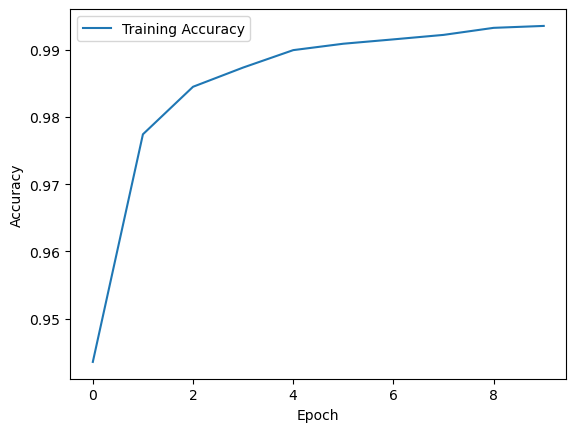

In [163]:
plt.plot(result_m2.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

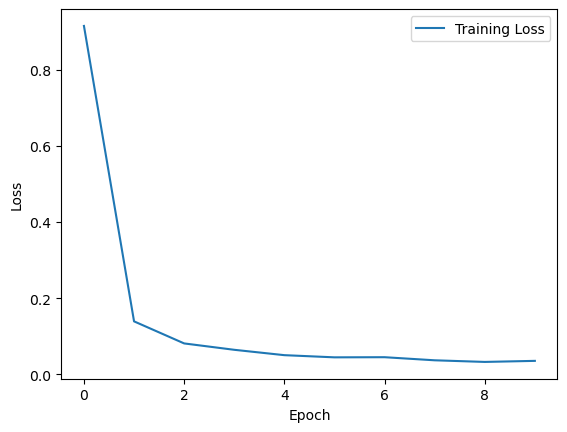

In [164]:
plt.plot(result_m2.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 37ms/step


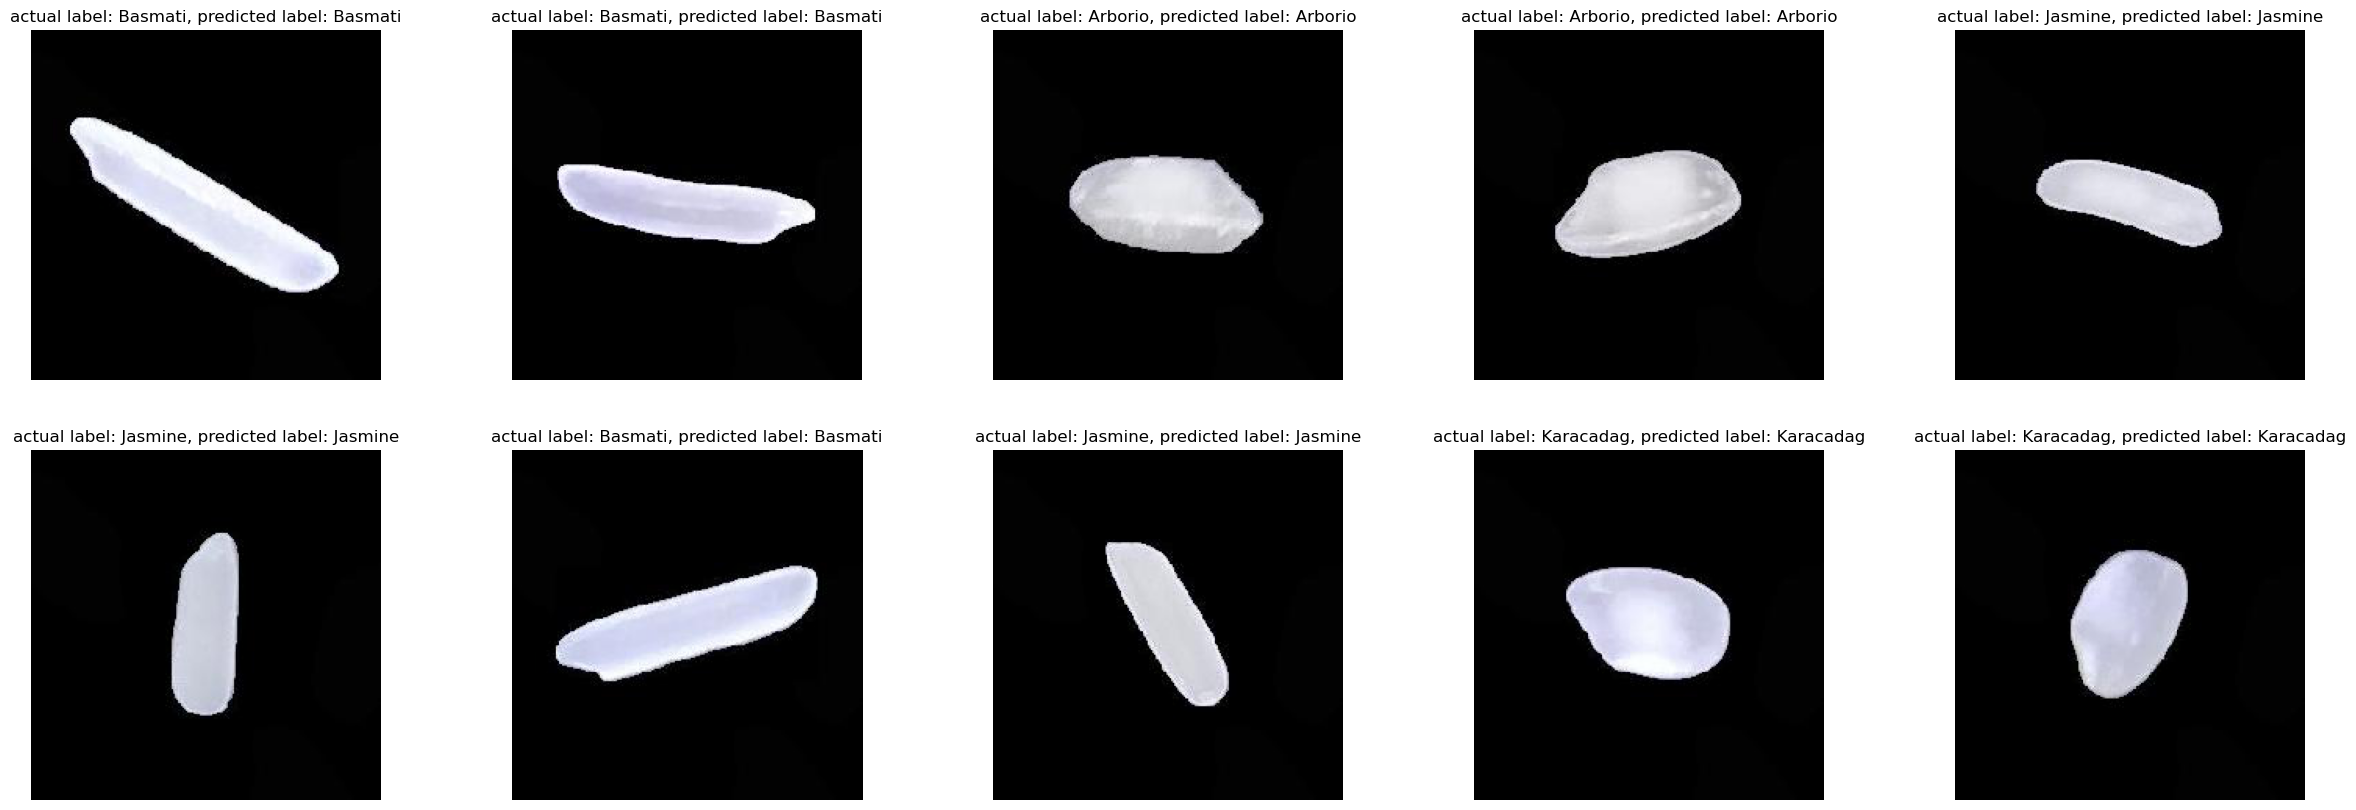

In [165]:
# use Model 2 to predict rice class
img, l = next(iter(test_generator))

plt.figure(figsize=(30,10))
for i in range(10):
    actual_label = list(label)[np.argmax(l[i])]
    predicted_label = np.argmax(model2.predict(img[i][None,...]))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(img[i]))
    plt.title(f'actual label: {actual_label}, predicted label: {list(label)[predicted_label]}')

### Model 3: DenseNet201

In [166]:
from tensorflow.keras.applications import DenseNet201

In [167]:
# Load pre-trained model
base_model3 = DenseNet201(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model3.trainable = False

In [168]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model3(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model3 = keras.Model(inputs, outputs)
model3.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten_20 (Flatten)        (None, 94080)             0         
                                                                 
 dense_40 (Dense)            (None, 32)                3010592   
                                                                 
 dense_41 (Dense)            (None, 5)                 165       
                                                                 
Total params: 21332741 (81.38 MB)
Trainable params: 3010757 (11.49 MB)
Non-trainable params: 18321984 (69.89 MB)
_________________________________________________________________


In [169]:
model3.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [170]:
# Fit the model
result_m3 = model3.fit(
    train_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
821/821 [==============================] - 761s 884ms/step - loss: 0.4775 - accuracy: 0.9691
Epoch 2/10
821/821 [==============================] - 686s 836ms/step - loss: 0.0673 - accuracy: 0.9887
Epoch 3/10
821/821 [==============================] - 687s 836ms/step - loss: 0.0483 - accuracy: 0.9921
Epoch 4/10
821/821 [==============================] - 693s 845ms/step - loss: 0.0556 - accuracy: 0.9919
Epoch 5/10
821/821 [==============================] - 696s 848ms/step - loss: 0.0458 - accuracy: 0.9935
Epoch 6/10
821/821 [==============================] - 693s 844ms/step - loss: 0.0567 - accuracy: 0.9938
Epoch 7/10
821/821 [==============================] - 701s 854ms/step - loss: 0.0290 - accuracy: 0.9952
Epoch 8/10
821/821 [==============================] - 693s 844ms/step - loss: 0.0249 - accuracy: 0.9956
Epoch 9/10
821/821 [==============================] - 687s 837ms/step - loss: 0.0233 - accuracy: 0.9961
Epoch 10/10
821/821 [==============================] - 689s 840m

In [172]:
model3.evaluate(test_generator)

352/352 [==============================] - 361s 947ms/step - loss: 0.0807 - accuracy: 0.9911


[0.08067534863948822, 0.9911110997200012]

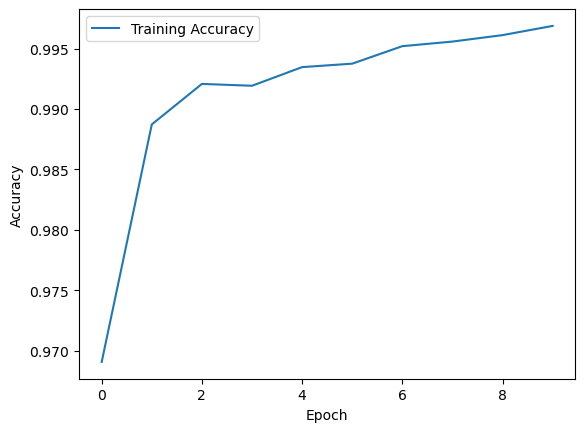

In [173]:
plt.plot(result_m3.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

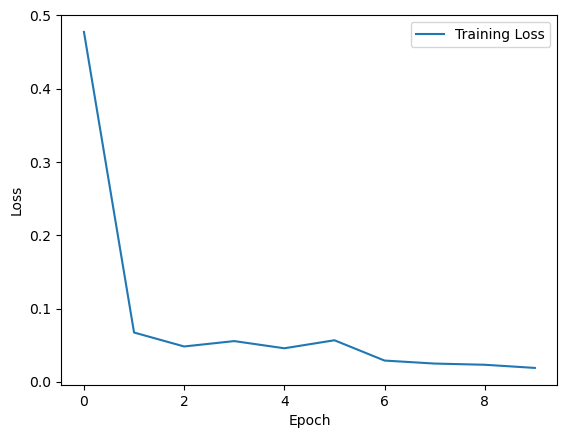

In [174]:
plt.plot(result_m3.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 100ms/step


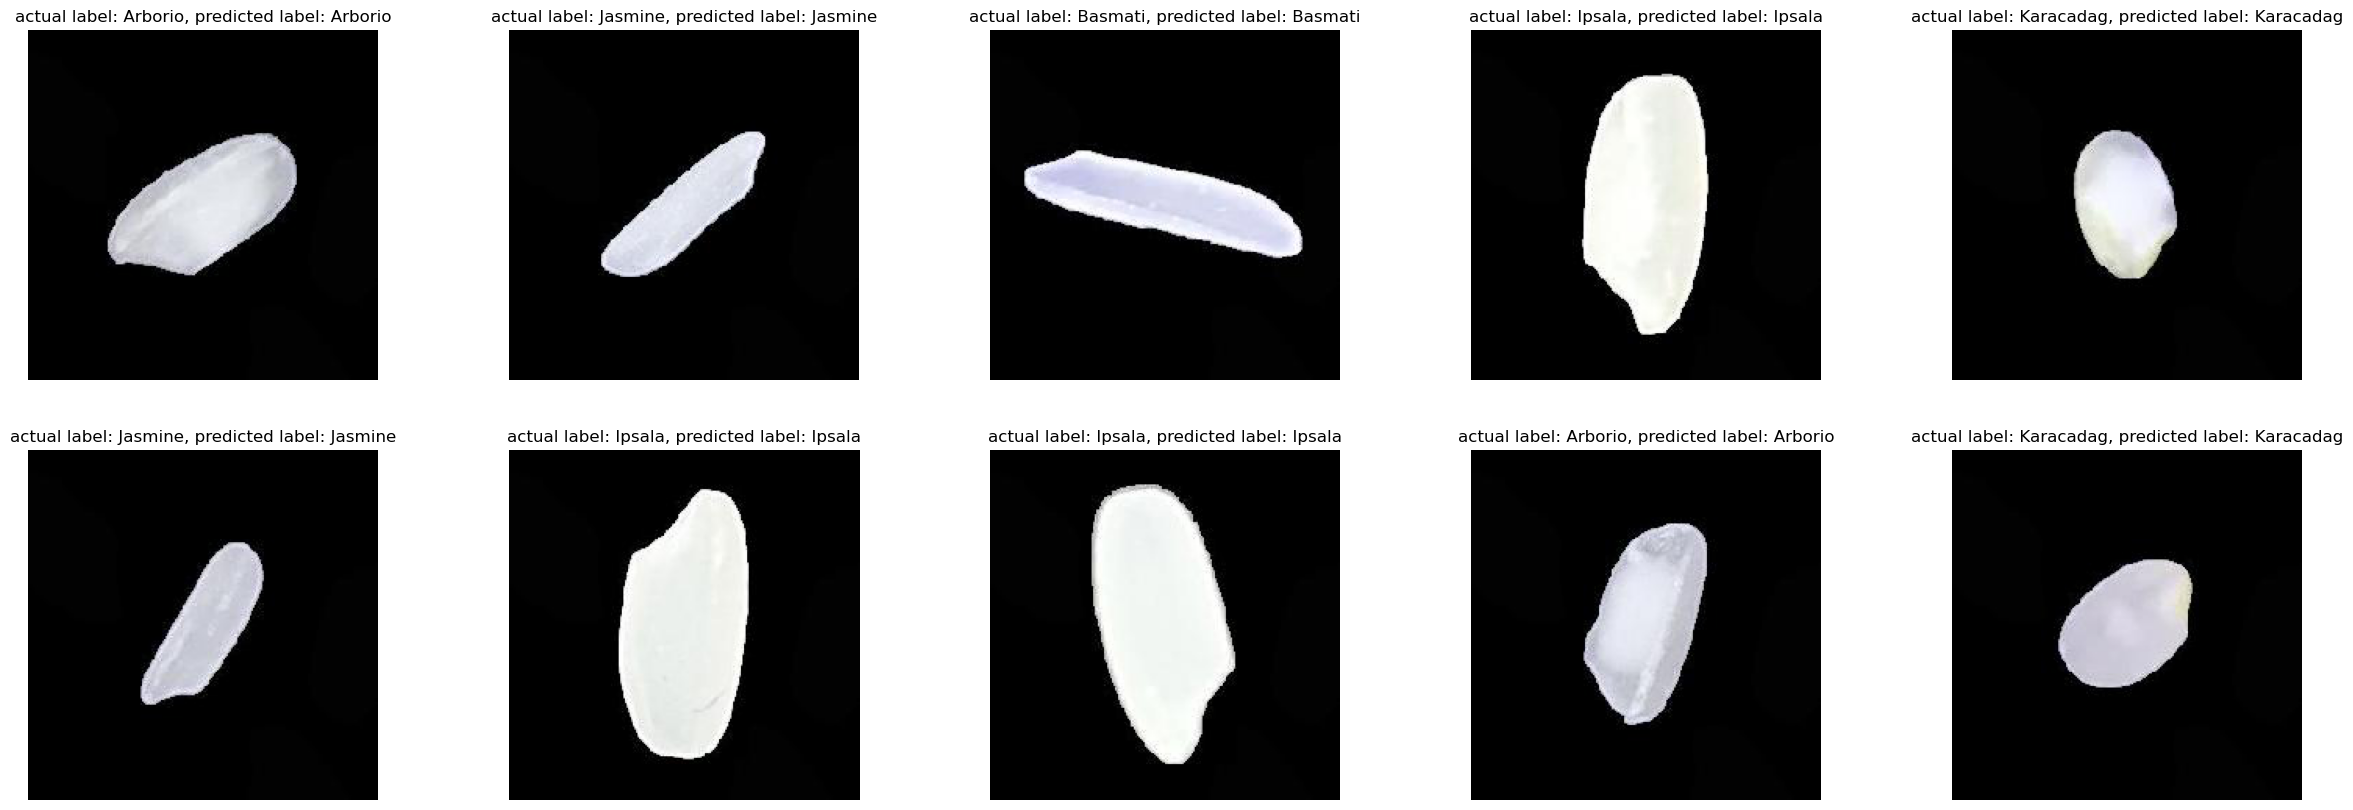

In [175]:
# use Model 3 to predict rice class
img, l = next(iter(test_generator))

plt.figure(figsize=(30,10))
for i in range(10):
    actual_label = list(label)[np.argmax(l[i])]
    predicted_label = np.argmax(model3.predict(img[i][None,...]))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(img[i]))
    plt.title(f'actual label: {actual_label}, predicted label: {list(label)[predicted_label]}')

### Model 4 - MobileNetV2

In [176]:
from tensorflow.keras.applications import MobileNetV2

In [177]:
# Load pre-trained model
base_model4 = MobileNetV2(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model4.trainable = False

In [178]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model4(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model4 = keras.Model(inputs, outputs)
model4.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_21 (Flatten)        (None, 62720)             0         
                                                                 
 dense_42 (Dense)            (None, 32)                2007072   
                                                                 
 dense_43 (Dense)            (None, 5)                 165       
                                                                 
Total params: 4265221 (16.27 MB)
Trainable params: 2007237 (7.66 MB)
Non-trainable params: 2257984 (8.61 MB)
_______________

In [179]:
model4.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [180]:
# Fit the model
result_m4 = model4.fit(
    train_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
821/821 [==============================] - 166s 193ms/step - loss: 3.8730 - accuracy: 0.9312
Epoch 2/10
821/821 [==============================] - 148s 181ms/step - loss: 0.3070 - accuracy: 0.9744
Epoch 3/10
821/821 [==============================] - 148s 180ms/step - loss: 0.2105 - accuracy: 0.9799
Epoch 4/10
821/821 [==============================] - 149s 181ms/step - loss: 0.1592 - accuracy: 0.9833
Epoch 5/10
821/821 [==============================] - 150s 183ms/step - loss: 0.1305 - accuracy: 0.9845
Epoch 6/10
821/821 [==============================] - 150s 182ms/step - loss: 0.0978 - accuracy: 0.9879
Epoch 7/10
821/821 [==============================] - 148s 180ms/step - loss: 0.0953 - accuracy: 0.9876
Epoch 8/10
821/821 [==============================] - 147s 180ms/step - loss: 0.0979 - accuracy: 0.9879
Epoch 9/10
821/821 [==============================] - 148s 181ms/step - loss: 0.0867 - accuracy: 0.9897
Epoch 10/10
821/821 [==============================] - 151s 184m

In [181]:
model4.evaluate(test_generator)

352/352 [==============================] - 76s 199ms/step - loss: 0.1876 - accuracy: 0.9838


[0.18756677210330963, 0.983822226524353]

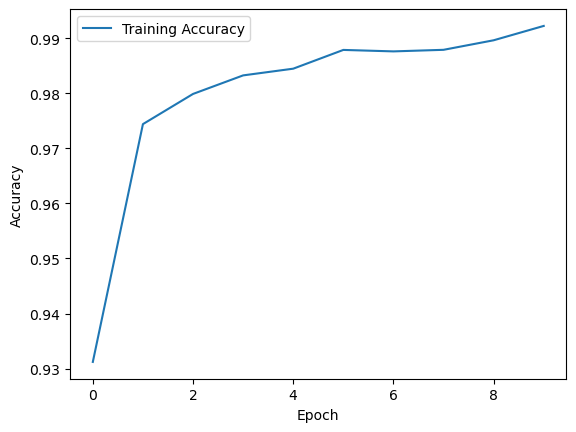

In [182]:
plt.plot(result_m4.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

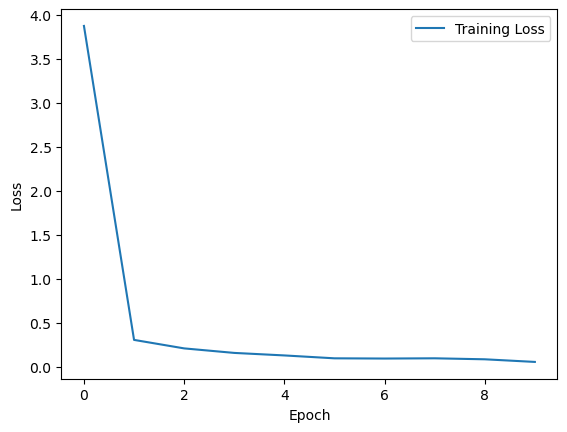

In [183]:
plt.plot(result_m4.history['loss'], label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 27ms/step


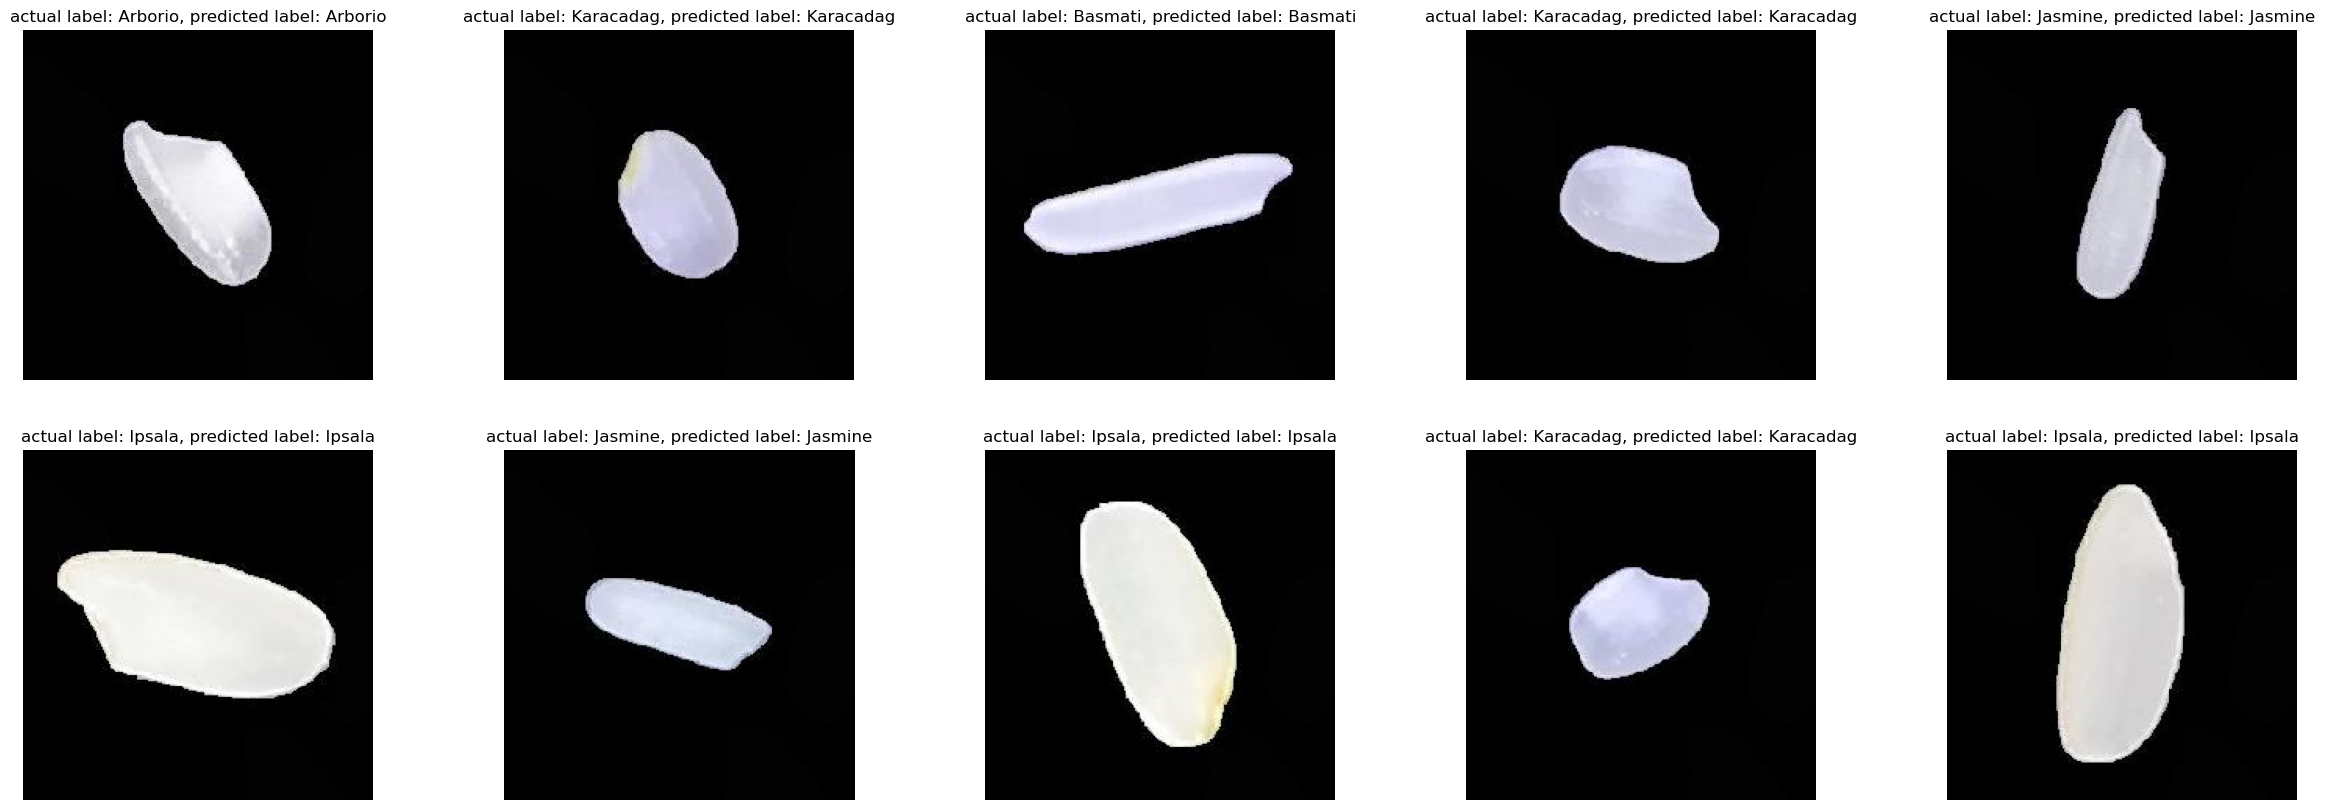

In [184]:
# use Model 4 to predict rice class
img, l = next(iter(test_generator))

plt.figure(figsize=(30,10))
for i in range(10):
    actual_label = list(label)[np.argmax(l[i])]
    predicted_label = np.argmax(model4.predict(img[i][None,...]))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(img[i]))
    plt.title(f'actual label: {actual_label}, predicted label: {list(label)[predicted_label]}')

### Model 5 - VGG19

In [185]:
from tensorflow.keras.applications import VGG19

In [186]:
# Load pre-trained model
base_model5 = VGG19(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model
base_model5.trainable = False

In [187]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model5(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(5, activation='softmax')(x)

model5 = keras.Model(inputs, outputs)
model5.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_22 (Flatten)        (None, 25088)             0         
                                                                 
 dense_44 (Dense)            (None, 32)                802848    
                                                                 
 dense_45 (Dense)            (None, 5)                 165       
                                                                 
Total params: 20827397 (79.45 MB)
Trainable params: 803013 (3.06 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [188]:
model5.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

In [189]:
# Fit the model
result_m5 = model5.fit(
    train_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
821/821 [==============================] - 500s 607ms/step - loss: 0.2574 - accuracy: 0.9332
Epoch 2/10
821/821 [==============================] - 496s 604ms/step - loss: 0.0645 - accuracy: 0.9818
Epoch 3/10
821/821 [==============================] - 495s 603ms/step - loss: 0.0464 - accuracy: 0.9861
Epoch 4/10
821/821 [==============================] - 496s 604ms/step - loss: 0.0397 - accuracy: 0.9877
Epoch 5/10
821/821 [==============================] - 496s 604ms/step - loss: 0.0386 - accuracy: 0.9877
Epoch 6/10
821/821 [==============================] - 496s 603ms/step - loss: 0.0332 - accuracy: 0.9890
Epoch 7/10
821/821 [==============================] - 496s 604ms/step - loss: 0.0262 - accuracy: 0.9917
Epoch 8/10
821/821 [==============================] - 505s 615ms/step - loss: 0.0283 - accuracy: 0.9906
Epoch 9/10
821/821 [==============================] - 2468s 3s/step - loss: 0.0273 - accuracy: 0.9914
Epoch 10/10
821/821 [==============================] - 2843s 3s/st

In [192]:
model5.evaluate(test_generator)

352/352 [==============================] - 215s 606ms/step - loss: 0.0518 - accuracy: 0.9856


[0.051754601299762726, 0.9856444597244263]

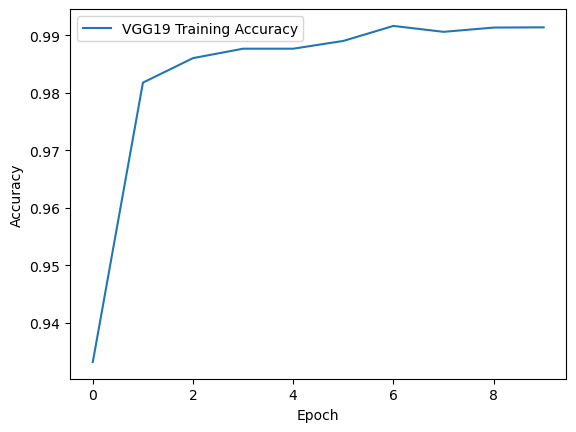

In [194]:
plt.plot(result_m5.history['accuracy'], label='VGG19 Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

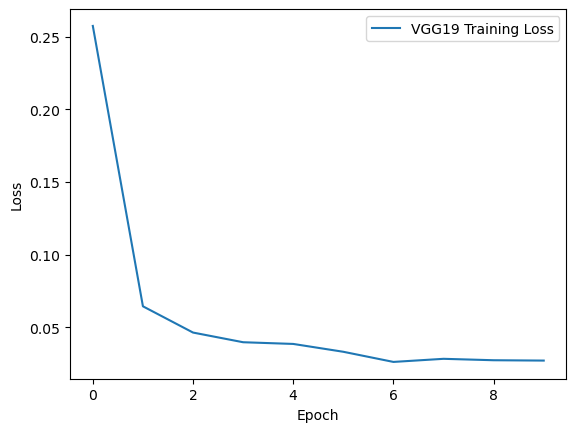

In [195]:
plt.plot(result_m5.history['loss'], label='VGG19 Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

1/1 [==============================] - 0s 12ms/step


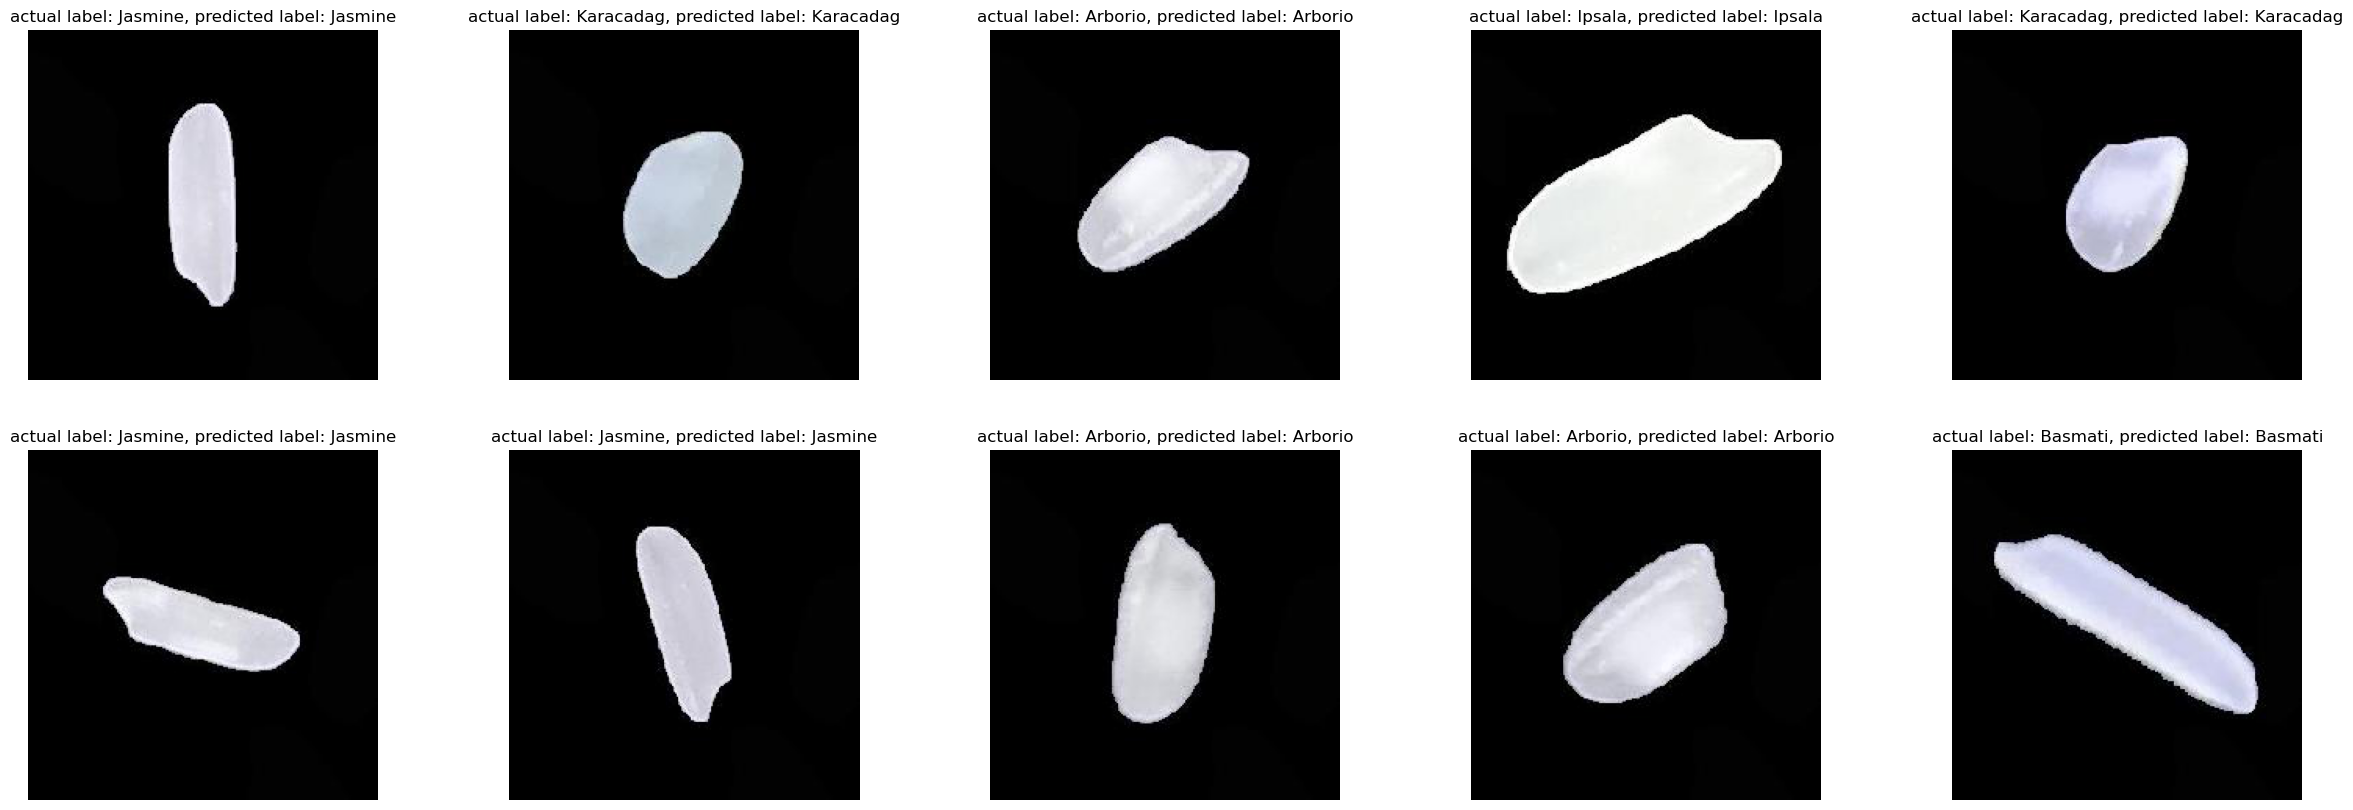

In [196]:
# use Model 5 to predict rice class
img, l = next(iter(test_generator))

plt.figure(figsize=(30,10))
for i in range(10):
    actual_label = list(label)[np.argmax(l[i])]
    predicted_label = np.argmax(model5.predict(img[i][None,...]))
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(tf.squeeze(img[i]))
    plt.title(f'actual label: {actual_label}, predicted label: {list(label)[predicted_label]}')

### Custom models

In [197]:
import splitfolders

In [198]:
# Load the same dataset
Dataset_path = pathlib.Path('./Rice_Image_Dataset')

In [199]:
splitfolders.ratio(Dataset_path, output='Images', seed=42, ratio=(.7,.3))

Copying files: 75000 files [00:25, 2956.00 files/s]


In [200]:
Img_Size = (250, 250)
seed = 42
Batch_Size = 32

In [201]:
Train = keras.utils.image_dataset_from_directory(
    'Images/train',
    labels='inferred',
    label_mode='int',
    batch_size = Batch_Size,
    image_size = Img_Size,
    seed=seed,shuffle = True,
)
Test = keras.utils.image_dataset_from_directory(
    'Images/test',
    labels='inferred',
    label_mode='int',
    batch_size = Batch_Size,
    image_size = Img_Size,
    seed=seed,shuffle = True,
)

Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


In [202]:
Classes = [Train, Test]
for l in Classes:
    Class_labels = l.class_names
    print(Class_labels)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [203]:
def print_dataset_shapes(dataset, dataset_name):
    for image_batch, labels_batch in dataset:
        print(f"{dataset_name} Shape: {image_batch.shape} (Batches = {len(dataset)})")
        print(f"{dataset_name} Label: {labels_batch.shape}\n")
        break

In [204]:
datasets = [
    (Train, "Train"),
    (Test, "Test")
]

# Print shapes for each dataset
for dataset, dataset_name in datasets:
    print_dataset_shapes(dataset, dataset_name)

Train Shape: (32, 250, 250, 3) (Batches = 1641)
Train Label: (32,)

Test Shape: (32, 250, 250, 3) (Batches = 352)
Test Label: (32,)



In [205]:
font1 = {'family':'serif','size':12}
font2 = {'family':'serif','size':10}

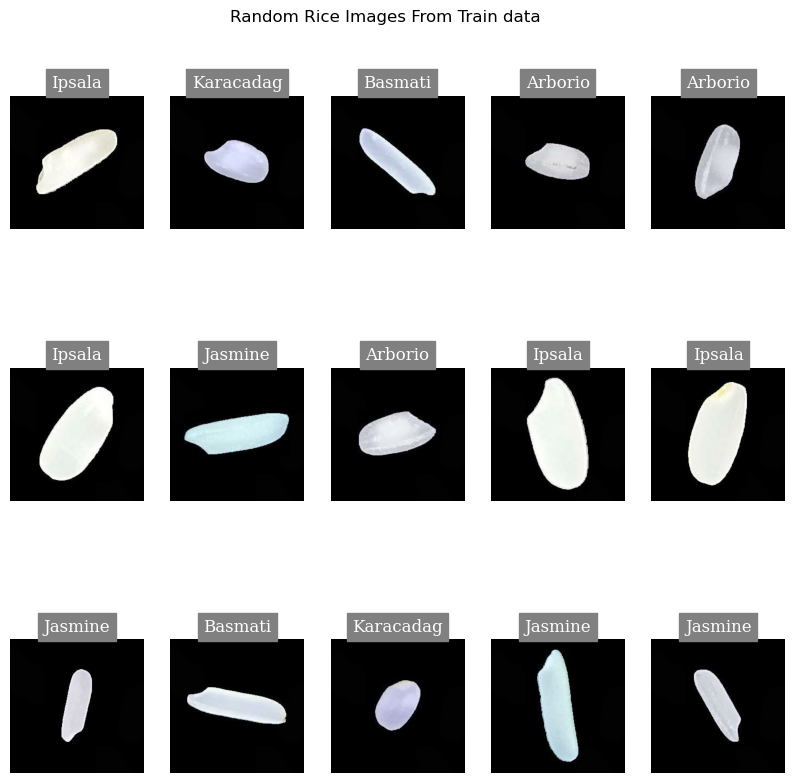

In [206]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for Image,Classes in Train.take(1): 
    for i in range(1,16):
        plt.subplot(3,5,i)
        plt.imshow(Image[i].numpy().astype("uint8"))
        plt.title(Class_labels[Classes[i]],backgroundcolor='grey',color='white',fontdict=font1)
        plt.axis("off")
        plt.suptitle('Random Rice Images From Train data', y=0.92)
plt.show()

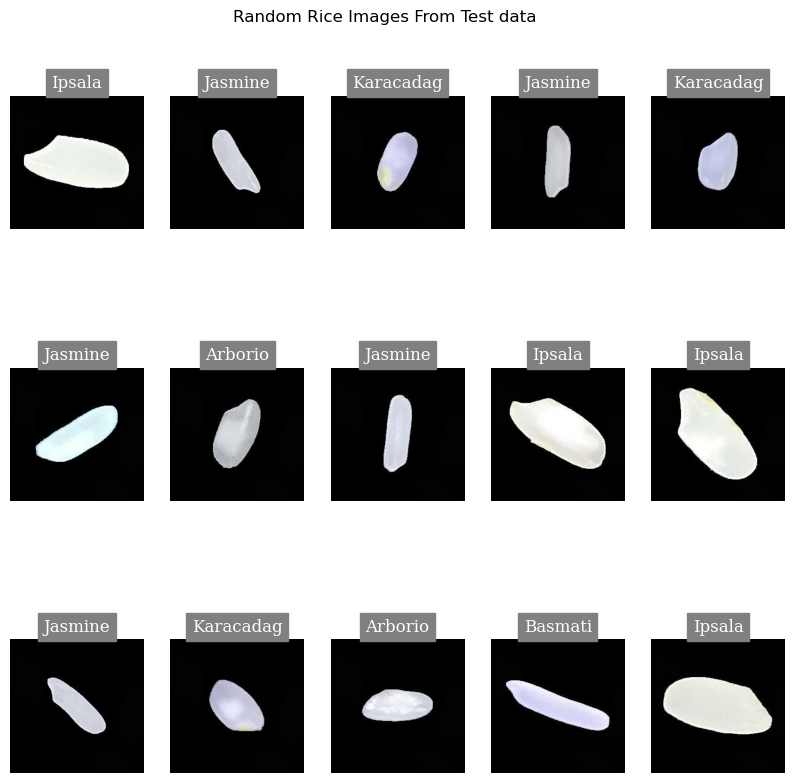

In [207]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for Image,Classes in Test.take(1): 
    for i in range(1,16):
        plt.subplot(3,5,i)
        plt.imshow(Image[i].numpy().astype("uint8"))
        plt.title(Class_labels[Classes[i]],backgroundcolor='grey',color='white',fontdict=font1)
        plt.axis("off")
        plt.suptitle('Random Rice Images From Test data', y=0.92)
plt.show()

In [211]:
model6 = models.Sequential(
    [
        layers.Rescaling(1./255, input_shape=(250, 250, 3)),
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(units=512, activation='relu'),
        layers.Dropout(0.5),  # Adding dropout for regularization
        layers.Dense(units=5, activation='sigmoid')
    ]
)

# Compile the model
model6.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Summary of the model architecture
model6.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_286 (Conv2D)         (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 124, 124, 32)      0         
 ng2D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 492032)            0         
                                                                 
 dense_48 (Dense)            (None, 512)               251920896 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

In [212]:
def visualizing_results(history, model_name):
    font1 = {'family':'serif','size':15}
    font2 = {'family':'serif','size':12}
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy',color='b', marker='o')
    plt.xlabel('Epoch', fontsize=12,labelpad=16)
    plt.ylabel('Accuracy', fontsize=12,labelpad=16)
    plt.title(f'{model_name} - Training Accuracy',backgroundcolor='grey',color='white',fontdict=font1)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'], label='Train Loss',color='b', marker='o')
    plt.xlabel('Epoch', fontsize=12,labelpad=16)
    plt.ylabel('Loss', fontsize=12,labelpad=16)
    plt.title(f'{model_name} - Training Loss',backgroundcolor='grey',color='white',fontdict=font1)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [213]:
# Fit the model
result_m6 = model6.fit(
    Train,
    epochs=10,  
   verbose=1
)

Epoch 1/10
1641/1641 [==============================] - 418s 253ms/step - loss: 0.7572 - accuracy: 0.9270
Epoch 2/10
1641/1641 [==============================] - 412s 251ms/step - loss: 0.0942 - accuracy: 0.9728
Epoch 3/10
1641/1641 [==============================] - 408s 248ms/step - loss: 0.1021 - accuracy: 0.9736
Epoch 4/10
1641/1641 [==============================] - 411s 250ms/step - loss: 0.1190 - accuracy: 0.9747
Epoch 5/10
1641/1641 [==============================] - 408s 248ms/step - loss: 0.1998 - accuracy: 0.9747
Epoch 6/10
1641/1641 [==============================] - 410s 250ms/step - loss: 0.1833 - accuracy: 0.9811
Epoch 7/10
1641/1641 [==============================] - 408s 249ms/step - loss: 0.3566 - accuracy: 0.9783
Epoch 8/10
1641/1641 [==============================] - 408s 249ms/step - loss: 0.4522 - accuracy: 0.9814
Epoch 9/10
1641/1641 [==============================] - 408s 249ms/step - loss: 0.5039 - accuracy: 0.9827
Epoch 10/10
1641/1641 [=======================

In [215]:
model6.evaluate(Test)

352/352 [==============================] - 34s 93ms/step - loss: 0.9826 - accuracy: 0.9820


[0.9825844764709473, 0.9820444583892822]

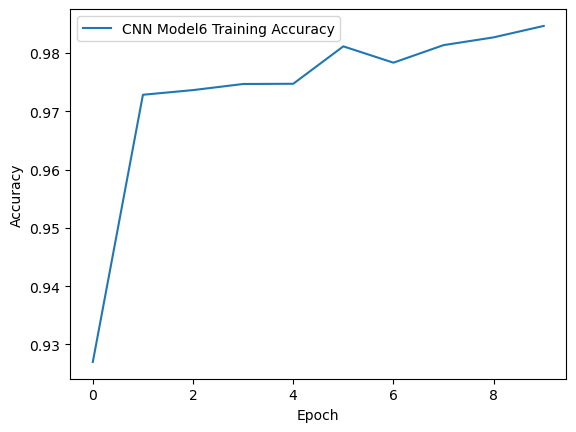

In [216]:
plt.plot(result_m6.history['accuracy'], label='CNN Model6 Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

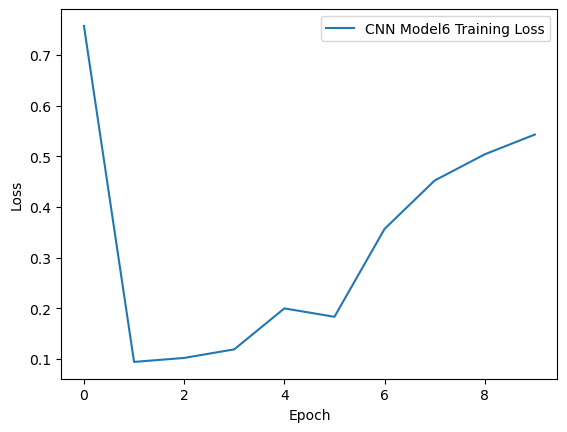

In [217]:
plt.plot(result_m6.history['loss'], label='CNN Model6 Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [227]:
model7 = models.Sequential(
    [
        layers.Rescaling(1./255, input_shape=(250, 250, 3)),
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=2, strides=2),
        # additional convolutional layer
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(units=512, activation='relu'),
        layers.Dropout(0.5),  # Adding dropout for regularization
        layers.Dense(units=5, activation='sigmoid')
    ]
)

# Compile the model
model7.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Summary of the model architecture
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_295 (Conv2D)         (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 124, 124, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_296 (Conv2D)         (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_29 (Flatten)        (None, 238144)           

In [219]:
# Fit the model
result_m7 = model7.fit(
    Train,
    epochs=10,  
   verbose=1
)

Epoch 1/10
1641/1641 [==============================] - 295s 177ms/step - loss: 0.1757 - accuracy: 0.9489
Epoch 2/10
1641/1641 [==============================] - 285s 174ms/step - loss: 0.1049 - accuracy: 0.9682
Epoch 3/10
1641/1641 [==============================] - 285s 174ms/step - loss: 0.1306 - accuracy: 0.9694
Epoch 4/10
1641/1641 [==============================] - 284s 173ms/step - loss: 0.1805 - accuracy: 0.9724
Epoch 5/10
1641/1641 [==============================] - 285s 174ms/step - loss: 0.3228 - accuracy: 0.9740
Epoch 6/10
1641/1641 [==============================] - 285s 174ms/step - loss: 0.8884 - accuracy: 0.9753
Epoch 7/10
1641/1641 [==============================] - 289s 176ms/step - loss: 1.6524 - accuracy: 0.9812
Epoch 8/10
1641/1641 [==============================] - 286s 174ms/step - loss: 2.2004 - accuracy: 0.9846
Epoch 9/10
1641/1641 [==============================] - 285s 174ms/step - loss: 3.1363 - accuracy: 0.9847
Epoch 10/10
1641/1641 [=======================

In [231]:
model7.evaluate(Test)

352/352 [==============================] - 26s 69ms/step - loss: 1.6176 - accuracy: 0.1601


[1.61763596534729, 0.16008888185024261]

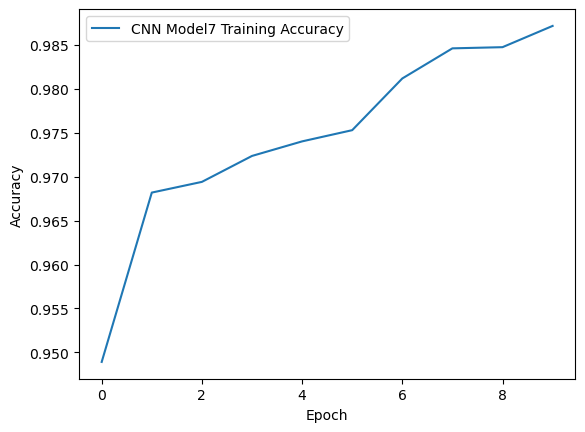

In [220]:
plt.plot(result_m7.history['accuracy'], label='CNN Model7 Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

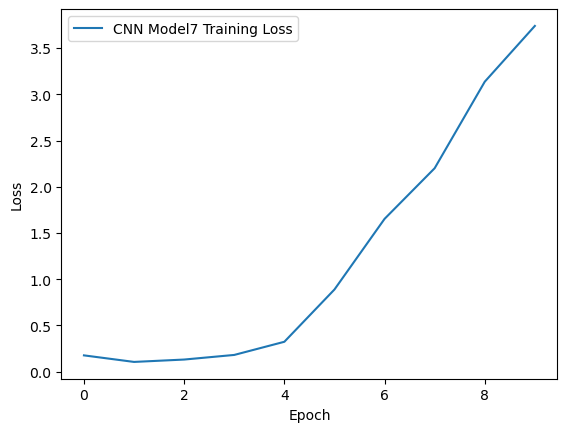

In [221]:
plt.plot(result_m7.history['loss'], label='CNN Model7 Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [229]:
model8 = models.Sequential(
    [
        layers.Rescaling(1./255, input_shape=(250, 250, 3)),
        layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=2, strides=2),
        # additional convolutional layer
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPool2D(pool_size=2, strides=2),
        layers.Flatten(),
        layers.Dense(units=512, activation='relu'),
        layers.Dropout(0.5),  # Adding dropout for regularization
        layers.Dense(units=5, activation='sigmoid')
    ]
)

# Compile the model
model8.compile(
    optimizer='RMSProp',
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Summary of the model architecture
model8.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_299 (Conv2D)         (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 124, 124, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_300 (Conv2D)         (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 61, 61, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_31 (Flatten)        (None, 238144)          

In [230]:
# Fit the model
result_m8 = model8.fit(
    Train,
    epochs=10,  
    verbose=1
)

Epoch 1/10
1641/1641 [==============================] - 681s 411ms/step - loss: 0.2299 - accuracy: 0.9464
Epoch 2/10
1641/1641 [==============================] - 666s 406ms/step - loss: 0.1034 - accuracy: 0.9690
Epoch 3/10
1641/1641 [==============================] - 660s 402ms/step - loss: 0.0855 - accuracy: 0.9753
Epoch 4/10
1641/1641 [==============================] - 660s 402ms/step - loss: 0.0814 - accuracy: 0.9788
Epoch 5/10
1641/1641 [==============================] - 662s 403ms/step - loss: 0.0782 - accuracy: 0.9814
Epoch 6/10
1641/1641 [==============================] - 653s 398ms/step - loss: 0.0726 - accuracy: 0.9830
Epoch 7/10
1641/1641 [==============================] - 648s 395ms/step - loss: 0.1347 - accuracy: 0.9825
Epoch 8/10
1641/1641 [==============================] - 2902s 2s/step - loss: 0.0793 - accuracy: 0.9839
Epoch 9/10
1641/1641 [==============================] - 664s 405ms/step - loss: 0.0835 - accuracy: 0.9854
Epoch 10/10
1641/1641 [=========================

In [232]:
model8.evaluate(Test)

352/352 [==============================] - 25s 67ms/step - loss: 0.1427 - accuracy: 0.9832


[0.14271853864192963, 0.9832000136375427]

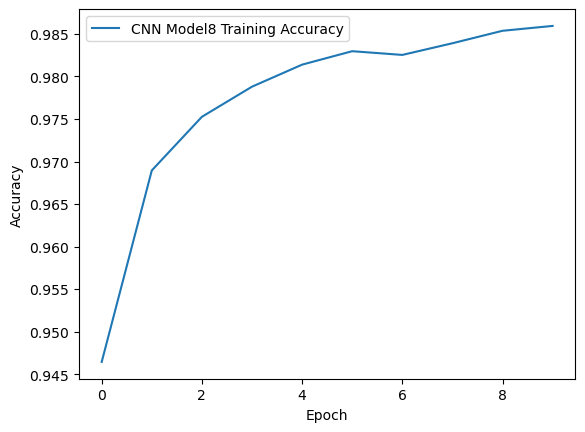

In [233]:
plt.plot(result_m8.history['accuracy'], label='CNN Model8 Training Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

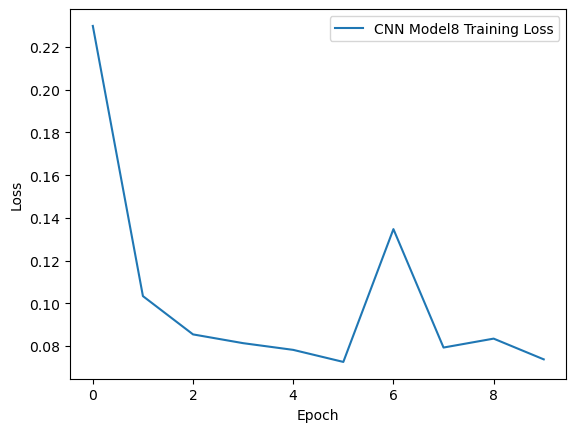

In [234]:
plt.plot(result_m8.history['loss'], label='CNN Model8 Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()